# NeuroBoostedTrees

This notebook is for :
"Resolving neuronal population code and  coordination with gradient boosted trees, Viejo et al, 2017"

We made an extensive use of [XGBoost][3] for analysing head-direction data.

Inspired by "[Modern machine learning far outperforms GLMs at predicting spikes, Benjamin et al, 2017][2]", we presents here some of the python function that we used to analyse XGBoost.

The dataset to use on this tutorial can be found [here.][1]

We mostly shown the scoring function when predicting firing rate activity and the function to dissect XGBoost i.e. the splitting positions and gains. If you are interested in something not shown here, the messy code can be found [here][4] or you can send us a message. 

 
## Table of content

0. Load and transform data
0. Looking at the prediction score
0. Importance of features 

[1]:www.peyrachelab.com/data/data_test_PP20.mat
[2]:http://biorxiv.org/content/early/2017/02/24/111450
[3]:http://xgboost.readthedocs.io/en/latest/
[4]:https://github.com/gviejo/Prediction_xgb_head_direction

## Dependencies

Basics
 - matplotlib
 - numpy
 - pandas
 - scipy
 - warnings
 - itertools
 
Methods
 - xgboost
 

In [2]:
import warnings
import pandas as pd
import scipy.io
import numpy as np
import sys, os
import itertools



## I. PREDICTING FIRING RATE WITH ANGULAR POSITION

### 1. Loading data

First, a dictionnary of array is loaded.
Keys are :
    - 'Ang' : the angular value
    - 'X'     : the x position 
    - 'Y'     : the y position
    - 'ADn'   : the antero-dorsal nucleus spiking activity (17 neurons)
    - 'Pos'   : the Post-subiculum spiking activity (15 neurons)
    - 'speed' : the speed of the animal

In [9]:
#####################################################################
# DATA LOADING
#####################################################################
#head direction data
hd_data = scipy.io.loadmat('../python/data_test_boosted_tree_20ms.mat') # 20 ms is the size of the time bin
print(hd_data.keys())


['Ang', 'Pos', '__header__', '__globals__', 'ADn', 'Y', 'X', '__version__', 'speed']


### 2. Integrating data into panda frame

Pandas make life much easier when learning with different subgroups of neurons. It allows to retrive quickly time series.
Neurons are ordered based on their tuning curves (from 0 to 2pi). When included in pandas, they are named with the same order such as ['ADn.0', 'ADn.1', 'ADn.2', ...].


In [14]:
data            =   pd.DataFrame()
data['time']    =   np.arange(len(hd_data['Ang']))     
data['ang']     =   hd_data['Ang'].flatten()            
data['x']       =   hd_data['X'].flatten()              
data['y']       =   hd_data['Y'].flatten()              
data['vel']     =   hd_data['speed'].flatten()
# neurons activity 
for i in xrange(hd_data['Pos'].shape[1]): data['Pos'+'.'+str(i)] = hd_data['Pos'][:,i]
for i in xrange(hd_data['ADn'].shape[1]): data['ADn'+'.'+str(i)] = hd_data['ADn'][:,i]

print data.keys()

Index([u'time', u'ang', u'x', u'y', u'vel', u'Pos.0', u'Pos.1', u'Pos.2',
       u'Pos.3', u'Pos.4', u'Pos.5', u'Pos.6', u'Pos.7', u'Pos.8', u'Pos.9',
       u'Pos.10', u'Pos.11', u'Pos.12', u'Pos.13', u'Pos.14', u'ADn.0',
       u'ADn.1', u'ADn.2', u'ADn.3', u'ADn.4', u'ADn.5', u'ADn.6', u'ADn.7',
       u'ADn.8', u'ADn.9', u'ADn.10', u'ADn.11', u'ADn.12', u'ADn.13',
       u'ADn.14', u'ADn.15', u'ADn.16'],
      dtype='object')


### 3. Prediction score functions and cross validations

Scikit-learn must be installed from now.


In [16]:
from sklearn.model_selection import KFold

def poisson_pseudoR2(y, yhat, ynull):
    """ Compute the pseudo R2 score
        y : real firing rate
        yhat : predicted firing rate
        ynull : mean of the real firing rate
    """    
    yhat = yhat.reshape(y.shape)
    eps = np.spacing(1)
    L1 = np.sum(y*np.log(eps+yhat) - yhat)
    L1_v = y*np.log(eps+yhat) - yhat
    L0 = np.sum(y*np.log(eps+ynull) - ynull)
    LS = np.sum(y*np.log(eps+y) - y)
    R2 = 1-(LS-L1)/(LS-L0)
    return R2

def fit_cv(X, Y, algorithm, n_cv=10):
    """Performs cross-validated fitting. Returns (Y_hat, pR2_cv); a vector of predictions Y_hat with the
    same dimensions as Y, and a list of pR2 scores on each fold pR2_cv.
    X  = input data
    Y = spiking data
    algorithm = a function of (Xr, Yr, Xt) {training data Xr and response Yr and testing features Xt}
                and returns the predicted response Yt
    n_cv = number of cross-validations folds
    """
    if np.ndim(X)==1:
        X = np.transpose(np.atleast_2d(X))
    cv_kf = KFold(n_splits=n_cv, shuffle=True, random_state=42)
    skf  = cv_kf.split(X)
    Y_hat=np.zeros(len(Y))
    pR2_cv = list()
    for idx_r, idx_t in skf:
        Xr = X[idx_r, :]
        Yr = Y[idx_r]
        Xt = X[idx_t, :]
        Yt = Y[idx_t]           
        Yt_hat = eval(algorithm)(Xr, Yr, Xt)        
        Y_hat[idx_t] = Yt_hat
        pR2 = poisson_pseudoR2(Yt, Yt_hat, np.mean(Yr))
        pR2_cv.append(pR2)

    return Y_hat, pR2_cv


### 4. Learners definitions

As in the paper, we define :
    - xgb_run : XGBoost 
    - mb : the model-based tuning curves of the neuron
    - lin_comb : a simple linear regression
    - kernel : the kernel model that transforms the angular feature into a combination of cosinus and sinus

In [38]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression

def xgb_run(Xr, Yr, Xt):
    """ XGBoost model
        Return the predicted firing rate
    """
    params = {'objective': "count:poisson", #for poisson output
    'eval_metric': "poisson-nloglik", #loglikelihood loss
    'seed': 2925,
    'silent': 1,
    'learning_rate': 0.1,
    'min_child_weight': 2, 
    # 'subsample': 0.6, 
    'max_depth': 5, 
    'gamma': 0.5
    }    
    dtrain = xgb.DMatrix(Xr, label=Yr)
    dtest = xgb.DMatrix(Xt)
    num_round = 100
    bst = xgb.train(params, dtrain, num_round)
    Yt = bst.predict(dtest)
    return Yt

def mb(Xr, Yr, Xt):
    """ Compute the model-based tuning curve of the hd cells
        And return the predicted firing rate        
    """
    nb_bins = 60
    bins = np.linspace(np.vstack((Xr, Xt)).min(), np.vstack((Xr, Xt)).max()+1e-8, nb_bins+1)
    index = np.digitize(Xr, bins).flatten()    
    tcurve = np.array([np.sum(Yr[index == i]) for i in xrange(1, nb_bins+1)])
    occupancy = np.array([np.sum(index == i) for i in xrange(1, nb_bins+1)])
    tcurve = (tcurve/occupancy)*40.0  
    new_index = np.digitize(Xt, bins).flatten()    
    return tcurve[new_index-1]/40.0 

def lin_comb(Xr, Yr, Xt):
    """ Linear model
        Return the predicted firing rate
    """
    lr = LinearRegression()
    lr.fit(Xr, Yr)
    Yt = lr.predict(Xt)    
    #rectify outputs
    Yt = np.maximum(Yt,np.zeros(Yt.shape))
    return Yt 

def kernel(Xr, Yr, Xt):
    """ Kernel model, cos and sin of the angle to the linear model
        Return the predicted firing rate
    """
    newX = np.zeros((Xr.shape[0], 12)) # up to six order    
    newXt = np.zeros((Xt.shape[0], 12))
    for i, j in zip(xrange(1,7), xrange(0, 12, 2)):
        newX[:,j] = np.cos(i*Xr).flatten()
        newX[:,j+1] = np.sin(i*Xr).flatten()
        newXt[:,j] = np.cos(i*Xt).flatten()
        newXt[:,j+1] = np.sin(i*Xt).flatten()
    Yt = lin_comb(newX, Yr, newXt)    
    return Yt

### 5 Supervised learning

The function test_features take a list of features and a list of targets and do the supervised learning procedure with cross-validation.


In [39]:
def test_features(features, targets, learners):
    '''
    features : a list of features, for example ['ang', 'x', 'y']
    targets :  the list of neurons to predict ['ADn.0', 'ADn.1']
    learners : the list of model to use, for example ['xgb']        
    Return : dictionnary with for each models the score PR2 and Yt_hat (the prediction of the firing rate)
    '''
    X = data[features].values
    Y = data[targets].values    
    output = {method:{'PR2':[],'Yt_hat':[]} for method in learners}
    learners_ = list(learners)
    for i in xrange(Y.shape[1]):
        y = Y[:,i]        
        for method in learners_:        
            print('Running '+method+' to predict '+targets[i])                              
            Yt_hat, PR2 = fit_cv(X, y, algorithm = method, n_cv=8)       
            output[method]['Yt_hat'].append(Yt_hat)
            output[method]['PR2'].append(PR2)           
    for m in output.iterkeys():
        output[m]['Yt_hat'] = np.array(output[m]['Yt_hat'])
        output[m]['PR2'] = np.array(output[m]['PR2'])        
    return output
    

 All the combination to be learned is defined here through a dictionnary.

In [40]:
combination = {
    'Pos':  {
            'features'  :   ['ang'],
            'targets'   :   [i for i in list(data) if i.split(".")[0] == 'Pos'], 
            },          
    'ADn':  {
            'features'  :   ['ang'],
            'targets'   :   [i for i in list(data) if i.split(".")[0] == 'ADn'],
            }
}
print(combination['ADn'])
print(combination['Pos'])


{'features': ['ang'], 'targets': ['ADn.0', 'ADn.1', 'ADn.2', 'ADn.3', 'ADn.4', 'ADn.5', 'ADn.6', 'ADn.7', 'ADn.8', 'ADn.9', 'ADn.10', 'ADn.11', 'ADn.12', 'ADn.13', 'ADn.14', 'ADn.15', 'ADn.16']}
{'features': ['ang'], 'targets': ['Pos.0', 'Pos.1', 'Pos.2', 'Pos.3', 'Pos.4', 'Pos.5', 'Pos.6', 'Pos.7', 'Pos.8', 'Pos.9', 'Pos.10', 'Pos.11', 'Pos.12', 'Pos.13', 'Pos.14']}


The main loop

In [42]:
methods = ['mb', 'xgb_run', 'lin_comb', 'kernel']
final_data = {}
for g in np.sort(combination.keys()):
    features = combination[g]['features']
    targets = combination[g]['targets'] 
    results = test_features(features, targets, methods)        
    final_data[g] = results
    

Running mb to predict ADn.0
Running xgb_run to predict ADn.0
Running lin_comb to predict ADn.0
Running kernel to predict ADn.0
Running mb to predict ADn.1
Running xgb_run to predict ADn.1
Running lin_comb to predict ADn.1
Running kernel to predict ADn.1
Running mb to predict ADn.2
Running xgb_run to predict ADn.2
Running lin_comb to predict ADn.2
Running kernel to predict ADn.2
Running mb to predict ADn.3
Running xgb_run to predict ADn.3
Running lin_comb to predict ADn.3
Running kernel to predict ADn.3
Running mb to predict ADn.4
Running xgb_run to predict ADn.4
Running lin_comb to predict ADn.4
Running kernel to predict ADn.4
Running mb to predict ADn.5
Running xgb_run to predict ADn.5
Running lin_comb to predict ADn.5
Running kernel to predict ADn.5
Running mb to predict ADn.6
Running xgb_run to predict ADn.6
Running lin_comb to predict ADn.6
Running kernel to predict ADn.6
Running mb to predict ADn.7
Running xgb_run to predict ADn.7
Running lin_comb to predict ADn.7
Running kernel t

Let's plot the result for this dataset

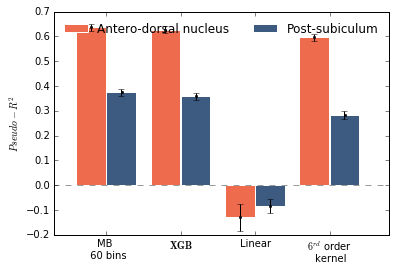

In [43]:
from matplotlib.pyplot import *

methods_to_plot = ['mb', 'xgb_run', 'lin_comb', 'kernel']
labels = {  'mb':'MB \n 60 bins', 
            'lin_comb':'Linear', 
            'nn':'NN', 
            'xgb_run':"$\mathbf{XGB}$",
            'h1':"Linear \n (cos$\\theta$, sin$\\theta$)",
            'kernel':"$6^{rd}$ order \n kernel"}
labels_plot = [labels[m] for m in methods_to_plot]
mean_pR2 = list()
sem_pR2 = list()
for model in methods_to_plot:
    PR2_art = final_data['ADn'][model]['PR2']
    mean_pR2.append(np.mean(PR2_art))
    sem_pR2.append(np.std(PR2_art)/np.sqrt(np.size(PR2_art)))        
bar(np.arange(np.size(mean_pR2)), mean_pR2, 0.4, align='center',
        ecolor='k', alpha=1, color='#EE6C4D', ec='w', yerr=np.array(sem_pR2), label = 'Antero-dorsal nucleus')
plot(np.arange(np.size(mean_pR2)), mean_pR2, 'k.', markersize=5)
mean_pR2 = list()
sem_pR2 = list()
for model in methods_to_plot:
    PR2_art = final_data['Pos'][model]['PR2']
    mean_pR2.append(np.mean(PR2_art))
    sem_pR2.append(np.std(PR2_art)/np.sqrt(np.size(PR2_art)))
bar(np.arange(np.size(mean_pR2))+0.405, mean_pR2, 0.4, align='center',
        ecolor='k', alpha=1, color='#3D5A80', ec='w', yerr=np.array(sem_pR2), label = 'Post-subiculum')
plot(np.arange(np.size(mean_pR2))+0.41, mean_pR2, 'k.', markersize=5)
plot([-1, len(methods_to_plot)], [0,0],'--k', alpha=0.4)
legend(loc='upper center', ncol=2, frameon = False)
xlim(-0.5,)
# ylim(0.0, 0.8)
xticks(np.arange(np.size(mean_pR2))+0.205, labels_plot)
ylabel("$Pseudo-R^2$")

show()

## II. ANALYSING SPLITS POSITIONS

#### a. Using p-R2 score per feature

- create the function to plot the feature importance

In [35]:
def bar_R2(R2_dict,f_compa,ta,nn):
    labels=[]
    mean=[]
    sem=[]
    a=0
    for l in f_compa.columns:
        K=np.zeros(nn)
        for i in range(nn):
            K[i]=np.mean(R2_dict[ta+'.'+str(i)][l])
        mean.append(np.mean(K))
        sem.append(np.std(K)/np.sqrt(np.size(K)))
        labels.append(l)
        a=a+1
    plt.bar(np.arange(np.size(mean)),mean, 0.8, align='center',
                    ecolor='k', alpha=.9, color='red', ec='w',yerr = sem ,
                    tick_label=labels)
    plt.plot(np.arange(np.size(mean)), mean, 'k.', markersize=15)
    plt.ylabel('Pseudo_R2')
    plt.show()

- Create the array with the features to compare

In [9]:
f_compa=data[[ 'ang', 'x', 'y', 'vel']]


- Function to create the dictionnary with the results for different neurons of one session. 

In [36]:
def comp_R2(f_compa,nn,ta,n_trees=50,depth=5):
    params = {'objective': "count:poisson", #for poisson output
        'eval_metric': "logloss", #loglikelihood loss
        'seed': 2925, #for reproducibility
        'silent': 1,
        'learning_rate': 0.05,
        'min_child_weight': 2, 'n_estimators': 580,
        'subsample': 0.6, 'max_depth': n_trees, 'gamma': 0.4}   
    R2_dict=dict()
    for i in range(nn):
        print(i)
        R2_dict[ta+'.'+str(i)]=dict()
        for keys in f_compa.columns:
            R2_dict[ta+'.'+str(i)][keys]=fit_cv(f_compa[keys].values,data[ta+'.'+str(i)].values,'xgb_run',params,n_trees, n_cv=8, verbose=1)[1]
    return R2_dict



In [ ]:
R2_dict=comp_R2(f_compa,nnPos,'Pos')
bar_R2(R2_dict,f_compa,ta,nn)

0
pR2_cv: 0.320640 (+/- 0.002164)
pR2_cv: 0.107286 (+/- 0.001905)
pR2_cv: 0.054016 (+/- 0.001395)
pR2_cv: 0.002525 (+/- 0.001126)
1
pR2_cv: 0.311384 (+/- 0.002595)
pR2_cv: 0.076674 (+/- 0.002462)
pR2_cv: 0.058048 (+/- 0.002629)
pR2_cv: -0.000094 (+/- 0.000838)
2
pR2_cv: 0.474184 (+/- 0.003484)
pR2_cv: 0.221788 (+/- 0.003022)
pR2_cv: 0.123434 (+/- 0.002846)
pR2_cv: 0.005792 (+/- 0.001005)
3
pR2_cv: 0.515440 (+/- 0.002409)
pR2_cv: 0.162379 (+/- 0.003947)
pR2_cv: 0.154952 (+/- 0.002447)
pR2_cv: 0.002363 (+/- 0.000529)
4
pR2_cv: 0.476049 (+/- 0.002651)
pR2_cv: 0.071112 (+/- 0.001641)
pR2_cv: 0.123703 (+/- 0.001790)
pR2_cv: 0.003311 (+/- 0.000636)
5
pR2_cv: 0.026449 (+/- 0.002820)
pR2_cv: -0.057542 (+/- 0.002879)
pR2_cv: -0.045759 (+/- 0.002685)
pR2_cv: -0.040627 (+/- 0.003119)
6


#### b. Looking at the split structure

- Function Spl to create a dictionay with the number of splits for each feature

In [15]:
import xgboost as xgb
import matplotlib.pyplot as plt

def Spl(X,y,n_trees=30,depth=2):
    params = {'objective': "count:poisson", #for poisson output
        'eval_metric': "logloss", #loglikelihood loss
        'seed': 2925, #for reproducibility
        'silent': 1,
        'learning_rate': 0.05,
        'min_child_weight': 0.1, 'n_estimators': 580,
        'subsample': 0.6, 'max_depth': depth, 'gamma': 0.4}  

    dtrain = xgb.DMatrix(X.values, label=y)
    num_round = n_trees
    bst = xgb.train(params, dtrain, num_round)

    Sp=extract_tree_threshold(bst)
    return Sp

def extract_tree_threshold(trees):
    n = len(trees.get_dump())
    thr = {}
    for t in range(n):
        gv = xgb.to_graphviz(trees, num_trees=t)
        body = gv.body
        for i in range(len(body)):
            for l in body[i].split('"'):
                if 'f' in l and '<' in l:
                    tmp = l.split("<")
                    if tmp[0] in thr:
                        thr[tmp[0]].append(float(tmp[1]))
                    else:
                        thr[tmp[0]] = [float(tmp[1])]
    for k in thr.keys():
        thr[k] = np.sort(np.array(thr[k]))
    return thr



- Function to plot the score distribution

In [ ]:
def bar_split(num_split,f_compa,ta,nn):
    labels=[]
    mean=[]
    sem=[]
    a=0
    for l in f_compa.columns:
        K=np.zeros(nn)
        for i in range(nn):
            if 'f'+str(a) in num_split[ta+'.'+str(i)].keys():
                K[i]=np.size(num_split[ta+'.'+str(i)]['f'+str(a)])
        mean.append(np.mean(K))
        sem.append(np.std(K)/np.sqrt(np.size(K)))
        labels.append(l)
        a=a+1
    plt.bar(np.arange(np.size(mean)),mean, 0.8, align='center',
                    ecolor='k', alpha=.9, color='red', ec='w',yerr = sem ,
                    tick_label=labels)
    plt.plot(np.arange(np.size(mean)), mean, 'k.', markersize=15)
    plt.ylabel('Number of splits')
    plt.show()

- Create the array with the features to compare

In [10]:
f_compa=data[[ 'ang', 'x', 'y', 'vel']]


- Create the dictionary  with the number of split distribution for each neuron

In [17]:
def Split_dict(f_compa,nn,ta,n_trees=30,depth=2):
    num_split=dict()
    for i in range(nn):
        print(i)
        num_split[ta+'.'+str(i)]=Spl(f_compa,data[ta+'.'+str(i)].values,n_trees,depth)
    return num_split

- Plot the split distribution

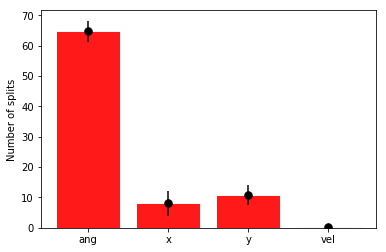

In [18]:
num_split=Split_dict(f_compa,nnPos,'Pos')
bar_split(num_split,f_compa,'Pos',nnPos)


#### c. Looking at the gain for feature importance

- Function to plot the gain repartition between features

In [33]:
def bar_gain(num_gain,f_compa,ta,nn):
    labels=[]
    mean=[]
    sem=[]
    for l in f_compa.columns:
        K=np.zeros(nn)
        for i in range(nn):
            if l in num_gain[ta+'.'+str(i)].keys():
                K[i]=np.sum(num_gain[ta+'.'+str(i)][l])
        mean.append(np.mean(K))
        sem.append(np.std(K)/np.sqrt(np.size(K)))
        labels.append(l)
    plt.bar(np.arange(np.size(mean)),mean, 0.8, align='center',
                    ecolor='k', alpha=.9, color='red', ec='w',yerr = sem ,
                    tick_label=labels)
    plt.plot(np.arange(np.size(mean)), mean, 'k.', markersize=15)
    plt.ylabel('Gain')
    plt.show()

- Function to create de dictionary with the gain distribution between features

In [20]:
def gain(X,Y,n_trees=30,depth=2):
    params = {'objective': "count:poisson", #for poisson output
    'eval_metric': "logloss", #loglikelihood loss
    'seed': 2925, #for reproducibility
    'silent': 1,
    'learning_rate': 0.05,
    'min_child_weight': 0, 'n_estimators': 580,
    'subsample': 0.6, 'max_depth': depth , 'gamma': 0.4}  

    dtrain = xgb.DMatrix(X,Y)     
    bst = xgb.train(params, dtrain, n_trees)
    return bst.get_score(importance_type = 'gain')

- The gain result for each neuron

In [29]:
def Gain_dict(f_compa,nn,ta,n_trees=30,depth=5):
    num_gain=dict()
    for i in range(nn):
        print(i)
        num_gain[ta+'.'+str(i)]=gain(f_compa,data[ta+'.'+str(i)].values)
    return num_gain

- Plot the result

0
{'y': 5.308505555555554, 'x': 5.55528, 'ang': 33.51814666666667}
1
{'y': 28.426393333333337, 'ang': 23.460203333333332}
2
{'x': 16.681583000000003, 'ang': 59.1375811111111}
3
{'y': 35.7793827586207, 'ang': 71.88658327868852}
4
{'ang': 57.65636574444445}
5
{'ang': 0.6218805333333332}
6
{'ang': 11.971543666666667}
7
{'x': 1.8251996666666663, 'ang': 59.63356666666666}
8
{'x': 9.188319, 'ang': 45.354975}
9
{'y': 3.711468666666667, 'x': 121.88019999999999, 'ang': 167.62489785714286}
10
{'y': 4.7724408333333335, 'ang': 109.4583847435898}
11
{'y': 4.534171612903227, 'vel': 22.077650000000002, 'ang': 29.7401}
12
{'ang': 165.10487238888894}
13
{'ang': 8.059584500000001}
14
{'y': 51.19805294117647, 'ang': 452.7114287671232}


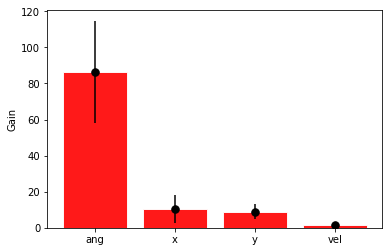

In [34]:
num_gain=Gain_dict(f_compa,nnPos,'Pos')
bar_gain(num_gain,f_compa,'Pos',nnPos)